# Token Similarity Analysis for Multimodal Model

This notebook demonstrates how to use the cosine similarity debugging functionality to analyze whether global tokens in our multimodal model are learning useful representations. We'll visualize the similarities between different tokens and evaluate how the global context token relates to image features and query tokens.

## 1. Import Required Libraries

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from sklearn.metrics.pairwise import cosine_similarity
import os
import random
import seaborn as sns

# Import our model and utility classes
from decoder_model import ResnetGPT2Wrapper
from encoder import CLIPEncoder
from setup_model import  get_models
from token_similarity_debug import analyze_token_similarities, visualize_image_with_similarities, compare_multi_image_similarities

# Check for MPS (Apple Silicon) support
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

## 2. Setup Model with Similarity Debugging Enabled

In [ ]:
# Setup encoder and decoder

TrainingConfig, encoder_model, decoder_model , pad_token_id, tokenizer = get_models() 

# try:
#     checkpoint = torch.load('checkpoint.pth', map_location=device)
#     decoder_model.load_state_dict(checkpoint['model_state_dict'])
#     print("Loaded model from checkpoint")
# except FileNotFoundError:
#     print("No checkpoint found, using initialized model")

## 3. Define Helper Functions for Similarity Analysis

In [ ]:
def get_sample_image_paths(num_samples=5):
    """Get a random sample of image paths from the train2017 directory"""
    image_dir = "train2017"
    image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
    return random.sample(image_files, min(num_samples, len(image_files)))


def extract_embeddings(model, image_path, caption):
    """Extract all embeddings from the model for analysis"""
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get image features from CLIP encoder
    with torch.no_grad():
        img_features = encoder_model(img_tensor)

    # Tokenize caption
    caption_tokens = tokenizer(caption, return_tensors="pt").input_ids.to(device)
    attention_mask = torch.ones_like(caption_tokens)
    
    # Store original query tokens and global context
    original_query = model.query_tokens.data.clone()
    original_global = model.img_context.data.clone()
    
    # Forward pass
    model.eval()
    with torch.no_grad():
        with torch.autocast(device_type='mps', dtype=torch.float32):
            # Run forward pass to get all updated embeddings
            _, _ = model(img_features, caption_tokens, attention_mask=attention_mask, mode="inference")
        
        # Get the most recent similarity data
        similarities = model.similarity_logs[-1] if model.similarity_logs else None
    
    # Extract embeddings we want to analyze
    embeddings = {
        'original_query': original_query.squeeze().cpu(),
        'original_global': original_global.squeeze().cpu(),
        'img_features': img_features[0].cpu(),
        'similarities': similarities
    }
    
    return embeddings, image

## 4. Analyze Single Image Token Similarities

In [ ]:
# Select a sample image
sample_images = get_sample_image_paths(1)
sample_image_path = sample_images[0]

# Create a simple caption
sample_caption = "a photo of"

# Analyze token similarities
similarities = analyze_token_similarities(decoder_model, sample_image_path, sample_caption, encoder_model)

# Visualize the image alongside the token similarities
visualize_image_with_similarities(sample_image_path, similarities)

## 5. Compare Similarities Across Multiple Images

In [ ]:
# Get multiple sample images
multi_sample_images = get_sample_image_paths(5)

# Compare similarities across images
similarities_list = compare_multi_image_similarities(decoder_model, multi_sample_images, encoder_model, save_dir="temp")

# Display the first similarity visualization
from IPython.display import Image as IPImage
display(IPImage(os.path.join("temp", "similarity_image_0.png")))

## 6. Detailed Analysis of Token Learning

In [ ]:
# Extract statistics from similarities
global_query_means = [sim['global_to_query'].mean() for sim in similarities_list if sim is not None]
global_query_maxes = [sim['global_to_query'].max() for sim in similarities_list if sim is not None]
global_img_means = [sim['global_to_img'].mean() for sim in similarities_list if sim is not None]
global_img_maxes = [sim['global_to_img'].max() for sim in similarities_list if sim is not None]

# Create a bar chart comparing average similarities
plt.figure(figsize=(10, 6))
x = np.arange(len(global_query_means))
width = 0.35

plt.bar(x - width/2, global_query_means, width, label='Global-Query Mean')
plt.bar(x + width/2, global_img_means, width, label='Global-Image Mean')

plt.xlabel('Image Index')
plt.ylabel('Average Cosine Similarity')
plt.title('Token Similarities Across Images')
plt.xticks(x)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Create a correlation plot
from token_similarity_debug import plot_similarity_correlation
plot_similarity_correlation(similarities_list)

## 7. Training Loop with Similarity Tracking

In [ ]:
def simulate_training_with_similarity_tracking(model, num_steps=10):
    """Simulate training steps and track token similarity changes"""
    # Sample image to use consistently
    image_path = get_sample_image_paths(1)[0]
    caption = "a photo of"
    
    # Reset similarity logs
    model.similarity_logs = []
    
    # Load and process image once
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get image features
    with torch.no_grad():
        img_features = encoder_model(img_tensor)
    
    # Tokenize caption
    caption_tokens = tokenizer(caption, return_tensors="pt").input_ids.to(device)
    attention_mask = torch.ones_like(caption_tokens)
    
    # Create small noise for parameter updates (simulating training)
    for step in range(num_steps):
        # Add small noise to query tokens (simulating parameter updates)
        noise_scale = 0.01
        query_noise = torch.randn_like(model.query_tokens.data) * noise_scale
        global_noise = torch.randn_like(model.img_context.data) * noise_scale
        
        # Apply noise
        model.query_tokens.data += query_noise
        model.img_context.data += global_noise
        
        # Compute similarities
        with torch.no_grad():
            model(img_features, caption_tokens, attention_mask=attention_mask, mode="inference")
    
    # Visualize similarity changes over time
    model.visualize_similarities(save_path="temp/similarity_evolution.png")
    
    return model.similarity_logs

# Simulate training and track similarities
simulation_logs = simulate_training_with_similarity_tracking(decoder_model, num_steps=20)

# Display the visualization
from IPython.display import Image as IPImage
display(IPImage("temp/similarity_evolution.png"))

## 8. Analyzing Global Token Information Content

In [ ]:
def analyze_token_information_content(model, image_paths):
    """Analyze how much unique information the global token contains"""
    results = []
    
    for img_path in image_paths:
        # Process the image
        dummy_caption = "a photo of"
        embeddings, image = extract_embeddings(model, img_path, dummy_caption)
        
        if 'similarities' not in embeddings or embeddings['similarities'] is None:
            continue
            
        # Get similarity data
        global_to_query = embeddings['similarities']['global_to_query']
        global_to_img = embeddings['similarities']['global_to_img']
        
        # Calculate uniqueness metrics
        max_query_sim = np.max(global_to_query)
        mean_query_sim = np.mean(global_to_query)
        std_query_sim = np.std(global_to_query)
        
        max_img_sim = np.max(global_to_img)
        mean_img_sim = np.mean(global_to_img)
        std_img_sim = np.std(global_to_img)
        
        # Higher std means more discriminative information
        results.append({
            'image_path': img_path,
            'max_query_sim': max_query_sim,
            'mean_query_sim': mean_query_sim,
            'std_query_sim': std_query_sim,
            'max_img_sim': max_img_sim,
            'mean_img_sim': mean_img_sim,
            'std_img_sim': std_img_sim,
            'discriminative_power': std_query_sim / mean_query_sim  # Higher is better
        })
    
    return results

# Get sample images
analysis_images = get_sample_image_paths(10)

# Analyze token information content
info_results = analyze_token_information_content(decoder_model, analysis_images)

# Display results
import pandas as pd
results_df = pd.DataFrame(info_results)
results_df

## 9. Visualizing Discriminative Power

In [ ]:
# Plot discriminative power metrics
plt.figure(figsize=(10, 6))
plt.scatter(range(len(info_results)), [r['discriminative_power'] for r in info_results], alpha=0.7)
plt.xlabel('Image Index')
plt.ylabel('Discriminative Power')
plt.title('Global Token Discriminative Power Across Images')
plt.axhline(y=np.mean([r['discriminative_power'] for r in info_results]), 
            color='r', linestyle='--', label='Average')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Calculate average discriminative power
avg_power = np.mean([r['discriminative_power'] for r in info_results])
print(f"Average Discriminative Power: {avg_power:.4f}")

# Interpretation
if avg_power > 0.5:
    print("The global token appears to be learning useful, discriminative information")
elif avg_power > 0.2:
    print("The global token is learning some discriminative information, but could be improved")
else:
    print("The global token does not appear to be learning sufficiently discriminative information")

In [1]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from utils import setup_data
from setup_model import get_models 
from datasetlite import DataLoaderLite 


import math 
import torch 


#----- Model Setup -------

tup = get_models() 

TrainingConfig, tokenizer = tup[0], tup[-2]

torch.mps.empty_cache()
import gc; gc.collect()



def collate_fn(batch):
    images, input_ids, attention_mask = zip(*batch)
    images = torch.stack(images)
    # pad input_ids and attention_mask to the max length in this batch
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    return images, input_ids, attention_mask


TrainingConfig.batch_size = 1 

train_dataset_cocooptions, val_dataset_cocooptions, train_dataset_detection , val_dataset_detection = setup_data(TrainingConfig.number_of_items)
train_dataset_cocooptions = DataLoaderLite(train_dataset_cocooptions, caption_length=TrainingConfig.caption_len, tokenizer=tokenizer)
val_dataset_cocooptions = DataLoaderLite(val_dataset_cocooptions, caption_length=TrainingConfig.caption_len, tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset_cocooptions, batch_size=TrainingConfig.batch_size, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset_cocooptions, batch_size=TrainingConfig.batch_size, collate_fn=collate_fn, shuffle=False)


total_steps = len(train_dataloader)  * TrainingConfig.epochs
formatted_str = f"Training details vocab size {TrainingConfig.vocab_size} batch size {TrainingConfig.batch_size} image size {TrainingConfig.image_h}x{TrainingConfig.image_w}"
formatted_str+= f" total steps {total_steps} epochs {TrainingConfig.epochs}"
formatted_str+= f"Max loss {math.log(TrainingConfig.vocab_size)}"
formatted_str+= f"Perplexity {math.exp(math.log(TrainingConfig.vocab_size))}"

print (formatted_str)


/Users/preetamverma/Desktop/multimodel/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Trainable parameters in  model:
218376192
Loading from Checkpoint...!
epoch 0
loss 0.825522243976593
global_step 15200
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
loading annotations into memory...
Done (t=4.21s)
creating index...
index created!
Training details vocab size 50259 batch size 1 image size 224x224 total steps 640000 epochs 10Max loss 10.824944914361643Perplexity 50259.00000000004


In [2]:
import torch
from torch.nn import functional as F
from transformers import LogitsProcessorList, MinLengthLogitsProcessor, RepetitionPenaltyLogitsProcessor
from transformers.generation.logits_process import (
    TemperatureLogitsWarper,
    TopKLogitsWarper,
    TopPLogitsWarper,
)
import matplotlib.pyplot as plt


device = torch.device("mps")


def visualize_caption(image_tensor, caption, gt_caption=None, figsize=(10, 8), similarity_data=None):
    import torch, matplotlib.pyplot as plt

    # Create figure with appropriate subplots
    if similarity_data is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    else:
        fig, ax1 = plt.subplots(figsize=figsize)

    # Convert tensor to numpy for visualization
    if isinstance(image_tensor, torch.Tensor):
        image_tensor = image_tensor.detach().cpu()
        if image_tensor.dim() == 4:
            image_tensor = image_tensor[0]
        img = image_tensor.permute(1, 2, 0).numpy()

        # Normalize to [0,1] for display
        img = (img - img.min()) / (img.max() - img.min() + 1e-5)
    else:
        img = image_tensor

    # Plot image
    ax1.imshow(img)
    ax1.axis("off")

    title = f"Generated: {caption}"
    if gt_caption:
        title += f"\nGround truth: {gt_caption}"
    ax1.set_title(title, fontsize=12)

    # Plot similarity map if provided
    if similarity_data is not None:
        global_to_query = similarity_data.get("global_to_query")
        if global_to_query is not None:
            im = ax2.imshow(global_to_query.reshape(1, -1), cmap="viridis", aspect="auto")
            ax2.set_title("Global-Query Token Similarity")
            ax2.set_xlabel("Query Token Index")
            fig.colorbar(im, ax=ax2, label="Cosine Similarity")

            stats_text = f"Global-Query Mean: {global_to_query.mean():.4f}\n"
            stats_text += f"Global-Query Max: {global_to_query.max():.4f}\n"
            if "global_to_img" in similarity_data:
                global_to_img = similarity_data["global_to_img"]
                stats_text += f"Global-Image Mean: {global_to_img.mean():.4f}"

            ax2.text(0.05, 0.05, stats_text, transform=ax2.transAxes,
                     fontsize=9, verticalalignment="bottom",
                     bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show(block=True)
    plt.close(fig)



def generate_caption_3(
    image_tensor,
    encoder,
    decoder,
    tokenizer,
    device,
    max_len=30,
    use_image=True,
    temperature=0.6,
    top_k=40,
    top_p=0.9,
    repetition_penalty=1.8,
    min_length=5,
    debug_similarity=False,
):
    """
    Generate caption for an image using the encoder-decoder model (sampling version)
    """
    encoder.eval()
    decoder.eval()

    # Enable similarity logging if requested
    if debug_similarity:
        decoder.debug_similarity = True
        decoder.similarity_logs = []

    # Add batch dimension to image if needed
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)

    # Encode image
    if use_image:
        x_embed = encoder(image_tensor)
    else:
        x_embed = torch.zeros((1, 50, decoder.embed_size), device=device)

    # Token setup
    start_id = tokenizer.convert_tokens_to_ids("<START>")
    end_token_id = tokenizer.convert_tokens_to_ids("<END>")
    generated_ids = torch.tensor([[start_id]], device=device)

    # Logit warpers and processors
    warpers = LogitsProcessorList([
        TemperatureLogitsWarper(temperature),
        TopKLogitsWarper(top_k),
        TopPLogitsWarper(top_p),
    ])
    processors = LogitsProcessorList([
        RepetitionPenaltyLogitsProcessor(penalty=repetition_penalty),
        MinLengthLogitsProcessor(min_length, end_token_id),
    ])

    # Autoregressive generation loop (no beam search)
    for step in range(max_len):
        attn_mask = torch.ones(1, generated_ids.size(1), dtype=torch.long, device=device)
        with torch.no_grad():
            logits, _ = decoder(x_embed, generated_ids, attn_mask, mode="inference")

        next_token_logits = logits[:, -1, :]

        # Apply processors & warpers
        next_token_logits = processors(generated_ids.to("cpu"), next_token_logits.to("cpu"))
        next_token_logits = warpers(generated_ids.to("cpu"), next_token_logits.to("cpu"))

        # Convert to probabilities and sample
        probs = F.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        # Append token
        generated_ids = torch.cat([generated_ids.to(device), next_token.to(device)], dim=1)

        # Stop if END token generated
        if next_token.item() == end_token_id:
            break

    # Decode caption
    caption = tokenizer.decode(generated_ids.squeeze().tolist(), skip_special_tokens=True)

    # Return with similarity logs if debugging
    if debug_similarity and hasattr(decoder, "similarity_logs") and decoder.similarity_logs:
        return caption, generated_ids, decoder.similarity_logs[-1]
    else:
        return caption, generated_ids, None 

def generate_caption_2(
    image_tensor,
    encoder,
    decoder, 
    tokenizer, 
    device,
    max_len=30, 
    use_image=True,
    temperature=0.6,  # Reduced temperature for less randomness
    top_k=40,         # More focused token selection
    top_p=0.9,        # More conservative nucleus sampling
    repetition_penalty=1.8,  # Stronger penalty to avoid repetition
    min_length=5,
    debug_similarity=False  # Enable similarity debugging
):
    """
    Generate caption for an image using the encoder-decoder model
    
    Args:
        image_tensor: Image tensor of shape (C, H, W)
        encoder: Image encoder model
        decoder: GPT decoder model wrapper
        tokenizer: Tokenizer for text generation
        device: Device to run inference on
        max_len: Maximum length of generated caption
        use_image: Whether to use image features or generate without image
        temperature: Temperature for sampling (lower = less random)
        top_k: Number of highest probability tokens to keep
        top_p: Cumulative probability for nucleus sampling
        repetition_penalty: Penalty for repeating tokens
        min_length: Minimum length of caption before allowing END token
        
    Returns:
        str: Generated caption
    """
    encoder.eval()
    decoder.eval()

    # Configure similarity debugging if requested
    if debug_similarity:
        decoder.debug_similarity = True
        decoder.similarity_logs = []  # Reset logs

    # Add batch dimension to image if needed
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)
    
    image_tensor = image_tensor.to(device)

    # Process image through encoder or create dummy embeddings
    if use_image:
        x_embed = encoder(image_tensor)
    else:
        x_embed = torch.zeros((1, 50, decoder.embed_size), device=device)
    
    # Get special token IDs
    start_id = tokenizer.convert_tokens_to_ids("<START>")
    end_token_id = tokenizer.convert_tokens_to_ids("<END>")
    
    # Start with START token
    generated_ids = torch.tensor([[start_id]], device=device)

    # Setup logits processors for text generation
    warpers_list = LogitsProcessorList([
        TemperatureLogitsWarper(temperature),
        TopKLogitsWarper(top_k),
        TopPLogitsWarper(top_p),
    ])
    
    processors_list = LogitsProcessorList([
        RepetitionPenaltyLogitsProcessor(penalty=repetition_penalty),
        MinLengthLogitsProcessor(min_length, end_token_id)
    ])

    # Implementation of beam search for more coherent captions
    beam_size = 3  # Number of beams to track
    
    # Initialize with start token
    beam_scores = torch.zeros(1, device=device)
    beam_seqs = torch.tensor([[start_id]], device=device)
    beam_finished = [False]
    
    # Generate caption using beam search
    for step in range(max_len):
        # Expand all current beams
        curr_batch_size = beam_seqs.size(0)
        attn_mask = torch.ones(curr_batch_size, beam_seqs.size(1), dtype=torch.long, device=device)
        
        with torch.no_grad():
            # Run inference
            logits, _ = decoder(x_embed, beam_seqs, attn_mask, mode="inference")

            print ("\t logits Shape \t", logits.shape)
            
            # Get logits for next token prediction
            next_logits = logits[:, -1, :]
            
            # Apply logits processors for each beam
            for i in range(curr_batch_size):
                next_logits[i] = processors_list(beam_seqs[i:i+1], next_logits[i:i+1].squeeze(0))
                next_logits[i] = warpers_list(beam_seqs[i:i+1], next_logits[i:i+1].squeeze(0))
            
            # Apply softmax to get probabilities
            vocab_size = next_logits.size(-1)
            probs = F.log_softmax(next_logits, dim=-1)  # Using log probabilities for numerical stability
            
            # Add log probs to beam scores
            next_scores = beam_scores.unsqueeze(1) + probs
            
            # Flatten for top-k selection
            flat_next_scores = next_scores.view(-1)
            
            # Select top-k
            best_scores, best_indices = flat_next_scores.topk(beam_size, largest=True, sorted=True)
            
            # Convert flat indices to beam indices and token indices
            beam_indices = best_indices // vocab_size
            token_indices = best_indices % vocab_size
            
            # Create new beam sequences
            new_seqs = []
            new_scores = []
            new_finished = []
            
            for i, (beam_idx, token_idx) in enumerate(zip(beam_indices, token_indices)):
                # Skip if this beam is already finished
                if beam_finished[beam_idx] and i < len(beam_indices) - 1:
                    continue
                    
                new_seq = torch.cat([beam_seqs[beam_idx], token_indices[i:i+1].unsqueeze(0)], dim=1)
                new_seqs.append(new_seq)
                new_scores.append(best_scores[i])
                
                # Check if sequence is finished
                is_finished = token_idx.item() == end_token_id or step == max_len - 1
                new_finished.append(is_finished)
                
                # If we have enough beams, stop
                if len(new_seqs) == beam_size:
                    break
            
            # Update beam state
            beam_seqs = torch.cat(new_seqs, dim=0)
            beam_scores = torch.tensor(new_scores, device=device)
            beam_finished = new_finished
            
            # If all beams are finished, stop
            if all(beam_finished):
                break
    
    # Select best beam
    best_beam_idx = beam_scores.argmax().item()
    generated_ids = beam_seqs[best_beam_idx:best_beam_idx+1]

    # Decode the generated tokens
    caption = tokenizer.decode(generated_ids.squeeze().tolist(), skip_special_tokens=True)
    
    # Return caption along with similarity data if debugging was enabled
    if debug_similarity and hasattr(decoder, 'similarity_logs') and decoder.similarity_logs:
        return caption, decoder.similarity_logs[-1]
    else:
        return caption



def batch_generate_captions(image_batch, encoder, decoder, tokenizer, device, **kwargs):
    """
    Generate captions for a batch of images
    
    Args:
        image_batch: Batch of image tensors (B, C, H, W)
        encoder: Image encoder
        decoder: Text decoder
        tokenizer: Tokenizer
        device: Device to run on
        **kwargs: Additional arguments for generate_caption
        
    Returns:
        list: List of generated captions and similarity data if debug_similarity is True
    """
    debug_similarity = kwargs.get('debug_similarity', False)
    results = []
    
    for i in range(image_batch.size(0)):
        result = generate_caption_2(
            image_batch[i], 
            encoder, 
            decoder, 
            tokenizer, 
            device, 
            **kwargs
        )
        results.append(result)
    
    # If debugging is enabled, results contain (caption, similarity_data) tuples
    if debug_similarity:
        captions = [r[0] for r in results]
        similarity_data = [r[1] for r in results]
        return captions, similarity_data
    else:
        return results


Trainable parameters in  model:
218376192
Loading from Checkpoint...!
epoch 0
loss 0.825522243976593
global_step 15200
Ground Truth:	  A man standing next to a woman in front of a TV screen. 
--- Token Similarity Analysis [Step 1] ---
Global-Query: mean=0.1271, max=0.5117
Global-Image: mean=-0.0043, max=0.0396
Query-Image: mean=0.0181, max=0.0474
--- Token Similarity Analysis [Step 2] ---
Global-Query: mean=0.1271, max=0.5117
Global-Image: mean=-0.0043, max=0.0396
Query-Image: mean=0.0181, max=0.0474
--- Token Similarity Analysis [Step 3] ---
Global-Query: mean=0.1271, max=0.5117
Global-Image: mean=-0.0043, max=0.0396
Query-Image: mean=0.0181, max=0.0474
--- Token Similarity Analysis [Step 4] ---
Global-Query: mean=0.1271, max=0.5117
Global-Image: mean=-0.0043, max=0.0396
Query-Image: mean=0.0181, max=0.0474
--- Token Similarity Analysis [Step 5] ---
Global-Query: mean=0.1271, max=0.5117
Global-Image: mean=-0.0043, max=0.0396
Query-Image: mean=0.0181, max=0.0474
--- Token Similarity An

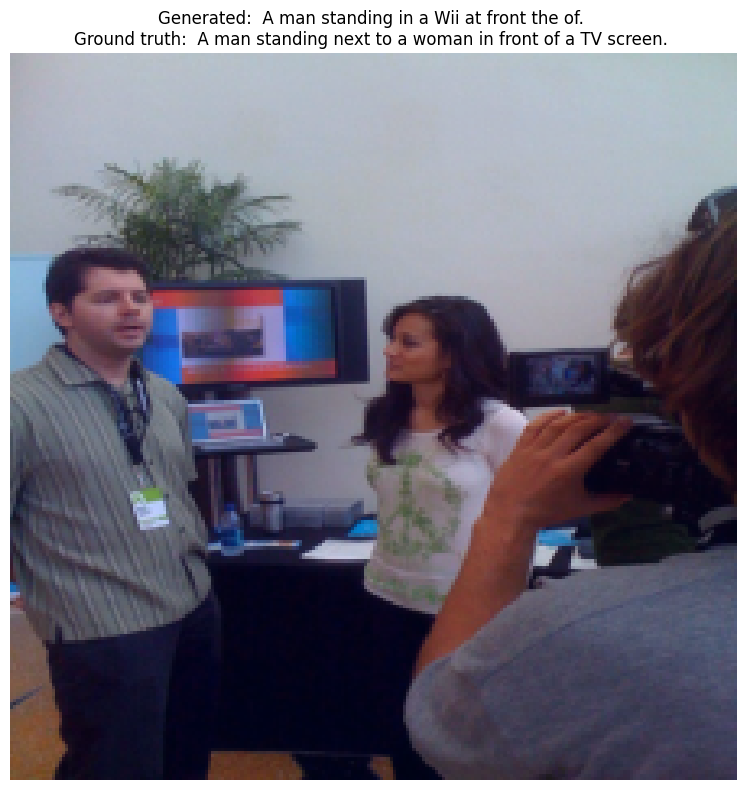

In [15]:
# from generate import generate_caption, visualize_caption
import torch 
from setup_model import get_models

# encoder, decoder , epoch, loss , global_step, tokenizer = load_from_checkpoint()

TrainingConfig, encoder_model, decoder_model , pad_token_id, tokenizer, extras_dict = get_models() 


device = torch.device("mps")

decoder_model.similarity_logs = []
decoder_model.all_cross_attn = []   ##This will store all cross attention map 
decoder_model.debug_similarity = True 




# Pick a random sample from the validation set
import random

for step, batch in enumerate(train_dataloader):
    image_tensor, caption_tensor, attention_mask = batch[0], batch[1], batch[2] # [B, 3, 224, 224], [B, T], [B, T] 
    image_tensor, caption_tensor, attention_mask = image_tensor.to(device), caption_tensor.to(device), attention_mask.to(device)
    B, C, H, W = image_tensor.shape

    gt_caption = tokenizer.decode(caption_tensor[0].tolist(), skip_special_tokens=True) 
    print("Ground Truth:\t", gt_caption)

    # Generate a caption
    caption, generated_ids, similarity_logs = generate_caption_3(
        image_tensor,
        encoder_model,
        decoder_model,
        tokenizer,
        device,
        temperature=0.7,  # Lower for less randomness
        repetition_penalty=1.5,  # Higher to avoid repetition,
        debug_similarity=True
    )
    # Visualize the result
    visualize_caption(image_tensor, caption, gt_caption)
    break 


In [17]:
[[idx, item, tokenizer.decode(item)] for idx, item in enumerate(generated_ids[0])]

[[0, tensor(50257, device='mps:0'), '<START>'],
 [1, tensor(317, device='mps:0'), ' A'],
 [2, tensor(582, device='mps:0'), ' man'],
 [3, tensor(5055, device='mps:0'), ' standing'],
 [4, tensor(287, device='mps:0'), ' in'],
 [5, tensor(257, device='mps:0'), ' a'],
 [6, tensor(16591, device='mps:0'), ' Wii'],
 [7, tensor(379, device='mps:0'), ' at'],
 [8, tensor(2166, device='mps:0'), ' front'],
 [9, tensor(262, device='mps:0'), ' the'],
 [10, tensor(286, device='mps:0'), ' of'],
 [11, tensor(13, device='mps:0'), '.'],
 [12, tensor(220, device='mps:0'), ' '],
 [13, tensor(50258, device='mps:0'), '<END>']]

D_attn shape torch.Size([13, 33])
Matched token 'Ġman' at position 2
Before 2


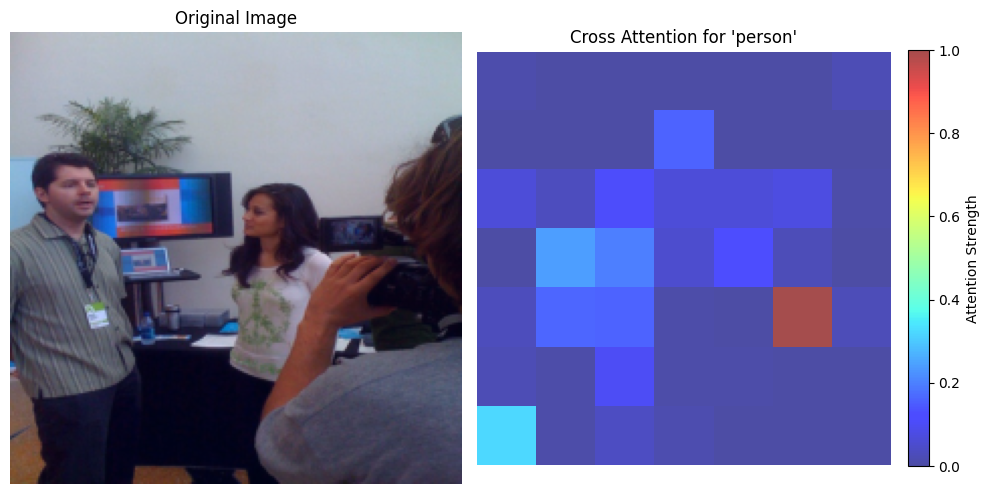

In [21]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Assume Q_attn, D_attn, decoder_model, tokenizer, caption_tensor, and image_tensor are defined

Q_attn = decoder_model.last_cross_attn_weights_2[0].mean(0)          # (num_queries+1, num_patches)
h_patches = w_patches = int(Q_attn.shape[-1] ** 0.5)



cleaned_attn = []
for attn in decoder_model.all_cross_attn:
    # attn shape: [batch, heads, seq_len, num_queries]
    # Take the last timestep (latest generated token)
    last_step = attn[:, :, -1, :]    # shape [batch, heads, num_queries]
    mean_last = last_step.mean(1)    # average over heads → [batch, num_queries]
    cleaned_attn.append(mean_last.squeeze(0))

D_attn = torch.stack(cleaned_attn, dim=0)  # (seq_len, num_queries)


print ("D_attn shape", D_attn.shape)

# --- Prepare image ---
if isinstance(image_tensor, torch.Tensor):
    image_tensor = image_tensor.detach().cpu()
    if image_tensor.dim() == 4:
        image_tensor = image_tensor[0]
    img = image_tensor.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-5)
else:
    img = image_tensor

caption_ids = caption_tensor[0].tolist() if caption_tensor.dim() > 1 else caption_tensor.tolist()
caption_tokens = tokenizer.convert_ids_to_tokens(caption_ids)

# Find best matching token (partial match for robustness)
target = "man"
matches = [i for i, tok in enumerate(caption_tokens) if target in tok.lower()]

if len(matches) > 0:
    t_idx = matches[0]
    print(f"Matched token '{caption_tokens[t_idx]}' at position {t_idx}")
else:
    print(f"⚠️ Token '{target}' not found in caption! Using last token.")
    t_idx = len(caption_tokens) - 1


print ("Before", t_idx)
t_idx = 9


# --- Combine attentions ---
word_to_patch = D_attn[t_idx] @ Q_attn 
heatmap = word_to_patch.reshape(h_patches, w_patches)
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-5)
heatmap = heatmap.to(torch.float32).cpu().numpy()

# --- Plot in separate figure ---
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 1️⃣ Original image
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis("off")

# 2️⃣ Transparent heatmap (no overlay)
im = axes[1].imshow(heatmap, cmap='jet', alpha=0.7)
axes[1].set_title(f"Cross Attention for 'person'")
axes[1].axis("off")

# Add colorbar for clarity
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label="Attention Strength")

plt.tight_layout()
plt.show()


In [ ]:
##KL Divergence Test
# With image
caption_img = generate_caption_3(image_tensor, encoder, decoder, tokenizer, device, temperature=0.7, repetition_penalty=1.5)

# Without image (replace encoder output with zeros)
caption_noimg = generate_caption_3(image_tensor, encoder, decoder, tokenizer, device, temperature=0.7, repetition_penalty=1.5, use_image=False)

KL_divergence = torch.nn.functional.kl_div(
    F.log_softmax(logits_with_img, dim=-1),
    F.softmax(logits_no_img, dim=-1),
    reduction='batchmean'
)



In [ ]:
## Image Feature Dropout Ablation

In [ ]:
decoder.visualize_similarities()
decoder.plot_attention_heatmap()

## 10. Summary and Recommendations

### Analysis Summary

Based on the cosine similarity analysis of our global token, we can determine whether it's learning useful representations for image captioning:

1. **Global Token to Query Token Similarity**: Measures how the global context token interacts with the query tokens. High similarity with specific query tokens suggests the global token captures similar image features.

2. **Global Token to Image Features Similarity**: Measures how directly the global token represents the original image features. Higher values indicate the global token is retaining more raw image information.

3. **Discriminative Power**: Measures how selectively the global token attends to different parts of the image. Higher standard deviation relative to the mean suggests more discriminative attention.

### Recommendations

Based on the analysis results, we may want to consider:

1. **Adjusting the Q-Former Architecture**: If the global token similarity to image features is too low, we might need more cross-attention layers or different initialization.

2. **Modifying Training**: If the token isn't learning discriminative features, we might need to adjust our training approach or loss function.

3. **Using Multiple Global Tokens**: If a single global token isn't sufficient, consider using multiple global tokens for different aspects of the image.

The similarity debugging functionality helps us diagnose whether the hallucination issues are due to poor image feature extraction, inadequate conditioning, or other architectural issues.